# Cluster evaluation

Evaluation through the comparison to existing data.

In [6]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray
import dataframe_image as dfi
from core.utils import get_cluster_names
import seaborn as sns
import matplotlib.pyplot as plt
import xvec
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Lato"]

v = "v10"

regions = gpd.read_parquet("/data/uscuni-ulce/regions/cadastre_regions_hull.parquet")

## CORINE Land Cover

In [3]:
# !wget https://copernicus-fme.eea.europa.eu/clmsdatadownload/results/146146.zip

In [4]:
# !mv 146146.zip /data/uscuni-ulce/validation/

In [7]:
corrine = gpd.read_file(
    "/data/uscuni-ulce/validation/Results/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg"
)

/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'U2018_CLC2018_V2020_20u1.gpkg': 'U2018_CLC2018_V2020_20u1' (default), 'U2018_CLC2018_V2020_20u1_FR_REU', 'U2018_CLC2018_V2020_20u1_FR_GLP', 'U2018_CLC2018_V2020_20u1_FR_GUF', 'U2018_CLC2018_V2020_20u1_FR_MTQ', 'U2018_CLC2018_V2020_20u1_FR_MYT'. Specify layer parameter to avoid this warning.
  result = read_func(


In [8]:
%%time
results = []
for region_id, region_hull in regions.iterrows():
    print(region_id)
    # setup regional data
    buildings = gpd.read_parquet(
        f"/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq"
    )
    regional_corrine = corrine[corrine.intersects(region_hull.convex_hull)].explode()

    ## spatially join buildings and corrine areas
    inp, res = buildings.centroid.sindex.query(
        regional_corrine.geometry, predicate="intersects"
    )
    assert (pd.Series(res).value_counts() == 1).all()
    buildings["Code_18"] = ""
    buildings.iloc[res, -1] = regional_corrine.iloc[inp, 0]

    results.append(buildings)

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


In [9]:
%%time
all_data = pd.concat(results, ignore_index=True)

CPU times: user 12.9 s, sys: 2.44 s, total: 15.3 s
Wall time: 15.3 s


In [10]:
corrine_legend = {
    "111": "Continuous urban fabric",
    "112": "Discontinuous urban fabric",
    "121": "Industrial or commercial units",
    "122": "Road and rail networks and associated land",
    "123": "Port areas",
    "124": "Airports",
    "131": "Mineral extraction sites",
    "132": "Dump sites",
    "133": "Construction sites",
    "141": "Green urban areas",
    "142": "Sport and leisure facilities",
    "211": "Non-irrigated arable land",
    "212": "Permanently irrigated land",
    "213": "Rice fields",
    "221": "Vineyards",
    "222": "Fruit trees and berry plantations",
    "223": "Olive groves",
    "231": "Pastures",
    "241": "Annual crops associated with permanent crops",
    "242": "Complex cultivation patterns",
    "243": "Land principally occupied by agriculture, with significant areas of natural vegetation",
    "244": "Agro-forestry areas",
}

In [11]:
cluster_mapping = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq"
)

### Level 3

In [12]:
%%time
all_data["map_label"] = all_data["final_without_noise"].map(
    cluster_mapping[3].to_dict()
)

CPU times: user 179 ms, sys: 116 ms, total: 295 ms
Wall time: 295 ms


In [13]:
himoc_corrine_cross_tab = pd.crosstab(
    all_data.map_label, all_data.Code_18, normalize="index"
)

# drop non-urban columns
relevant_corrine_columns = himoc_corrine_cross_tab.columns[
    himoc_corrine_cross_tab.columns.str.startswith("1")
    | himoc_corrine_cross_tab.columns.str.startswith("2")
]
himoc_corrine_cross_tab = himoc_corrine_cross_tab.loc[:, relevant_corrine_columns]

# map keys to names
himoc_corrine_cross_tab.index = himoc_corrine_cross_tab.index.map(
    get_cluster_names(3)
).values
himoc_corrine_cross_tab.columns = himoc_corrine_cross_tab.columns.map(
    corrine_legend
).values

In [14]:
# focus only on relative classes
himoc_corrine_cross_tab = himoc_corrine_cross_tab[
    [
        "Continuous urban fabric",
        "Discontinuous urban fabric",
        "Industrial or commercial units",
        "Non-irrigated arable land",
        "Pastures",
        "Complex cultivation patterns",
        "Land principally occupied by agriculture, with significant areas of natural vegetation",
    ]
].rename(columns={"Land principally occupied by agriculture, with significant areas of natural vegetation": "Land principally occupied by agriculture[...]"})

In [15]:
clc_l3 = himoc_corrine_cross_tab

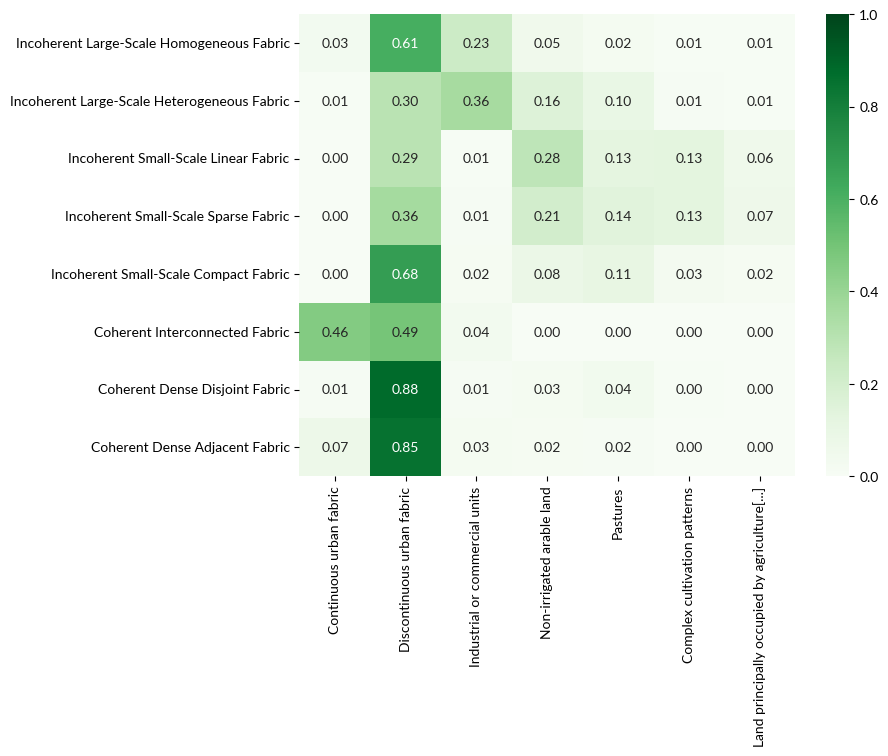

In [28]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(himoc_corrine_cross_tab, cmap='Greens', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax)
plt.savefig('../figs/corine_l3.png', dpi=300, bbox_inches="tight")

1. The clusters broadly follow the higher level patterns that are described by the corrine land cover classification
    - the Large Utilitarian Development	, Massive Connected Aggregations, Extensive Courtyard Complexes	, Large Wide-Spaced Complexes are mostly industrial units.
    - Large Interconnected Blocks	is the most urban cluster and half of it is contiguous urban fabric
    - Other types of clusters mostly fall within the Discontinuous urban fabric	cluster, which is expected
    - The sparse development captures some aggriculture and developed land patterns
2. We split the classes into different sub classes, providing more information
   - Discontinuous urban fabric is split into various classes based on the density, street characteristics and overall distances between buildings.
   - Similarly for the less developed clusters such as Linear Development, Sparse Road-Linked Development, Sparse Rural Development	 which contain lots of villages.

### Level 2

In [16]:
%%time
all_data["map_label"] = all_data["final_without_noise"].map(
    cluster_mapping[2].to_dict()
)

CPU times: user 214 ms, sys: 84.1 ms, total: 298 ms
Wall time: 298 ms


In [17]:
himoc_corrine_cross_tab = pd.crosstab(
    all_data.map_label, all_data.Code_18, normalize="index"
)

# drop non-urban columns
relevant_corrine_columns = himoc_corrine_cross_tab.columns[
    himoc_corrine_cross_tab.columns.str.startswith("1")
    | himoc_corrine_cross_tab.columns.str.startswith("2")
]
himoc_corrine_cross_tab = himoc_corrine_cross_tab.loc[:, relevant_corrine_columns]

# map keys to names
himoc_corrine_cross_tab.index = himoc_corrine_cross_tab.index.map(
    get_cluster_names(2)
).values
himoc_corrine_cross_tab.columns = himoc_corrine_cross_tab.columns.map(
    corrine_legend
).values

In [18]:
# focus only on relative classes
himoc_corrine_cross_tab = himoc_corrine_cross_tab[
    [
        "Continuous urban fabric",
        "Discontinuous urban fabric",
        "Industrial or commercial units",
        "Non-irrigated arable land",
        "Pastures",
        "Complex cultivation patterns",
        "Land principally occupied by agriculture, with significant areas of natural vegetation",
    ]
].rename(columns={"Land principally occupied by agriculture, with significant areas of natural vegetation": "Land principally occupied by agriculture[...]"})

In [19]:
clc_l2 = himoc_corrine_cross_tab

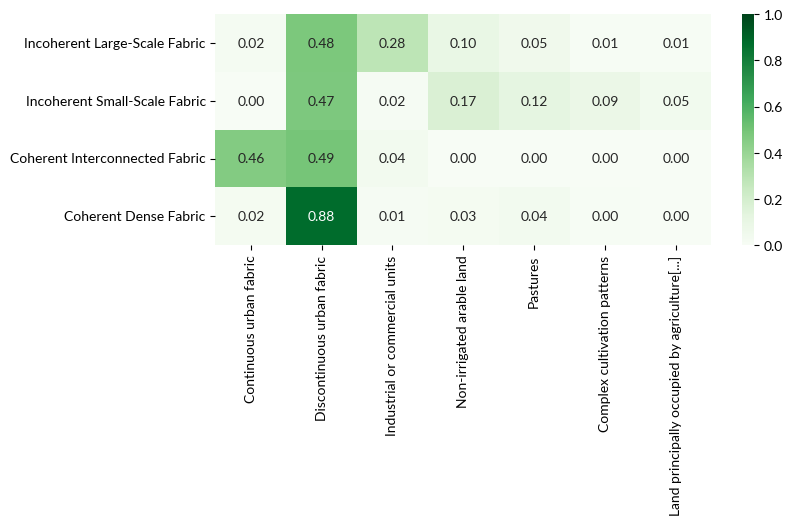

In [33]:
f, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(himoc_corrine_cross_tab, cmap='Greens', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax)
plt.savefig('../figs/corine_l2.png', dpi=300, bbox_inches="tight")

### Level 1

In [20]:
%%time
all_data["map_label"] = all_data["final_without_noise"].map(
    cluster_mapping[1].to_dict()
)

CPU times: user 218 ms, sys: 75.9 ms, total: 294 ms
Wall time: 294 ms


In [21]:
himoc_corrine_cross_tab = pd.crosstab(
    all_data.map_label, all_data.Code_18, normalize="index"
)

# drop non-urban columns
relevant_corrine_columns = himoc_corrine_cross_tab.columns[
    himoc_corrine_cross_tab.columns.str.startswith("1")
    | himoc_corrine_cross_tab.columns.str.startswith("2")
]
himoc_corrine_cross_tab = himoc_corrine_cross_tab.loc[:, relevant_corrine_columns]

# map keys to names
himoc_corrine_cross_tab.index = himoc_corrine_cross_tab.index.map(
    get_cluster_names(3)
).values
himoc_corrine_cross_tab.columns = himoc_corrine_cross_tab.columns.map(
    corrine_legend
).values

In [22]:
# focus only on relative classes
himoc_corrine_cross_tab = himoc_corrine_cross_tab[
    [
        "Continuous urban fabric",
        "Discontinuous urban fabric",
        "Industrial or commercial units",
        "Non-irrigated arable land",
        "Pastures",
        "Complex cultivation patterns",
        "Land principally occupied by agriculture, with significant areas of natural vegetation",
    ]
].rename(columns={"Land principally occupied by agriculture, with significant areas of natural vegetation": "Land principally occupied by agriculture[...]"})

In [23]:
clc_l1 = himoc_corrine_cross_tab

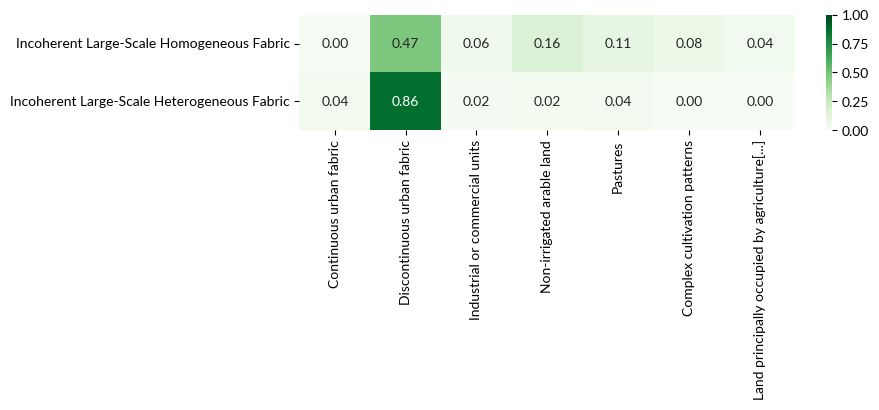

In [38]:
f, ax = plt.subplots(figsize=(8, 1.5))
sns.heatmap(himoc_corrine_cross_tab, cmap='Greens', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax)
plt.savefig('../figs/corine_l1.png', dpi=300, bbox_inches="tight")

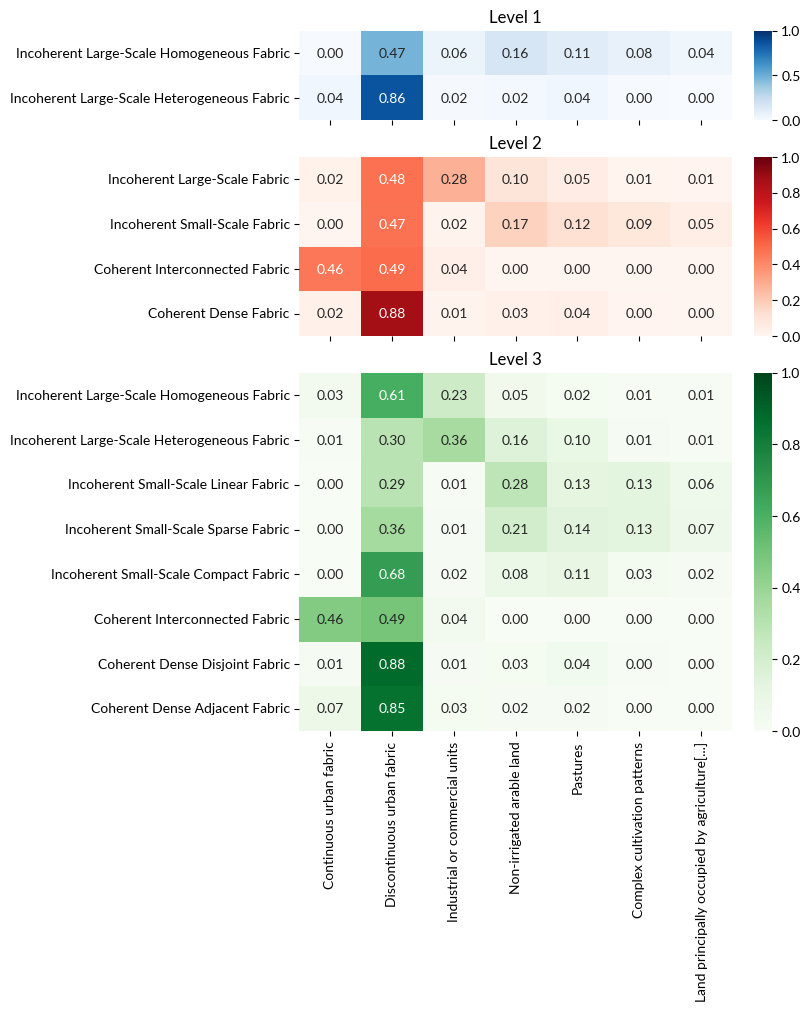

In [24]:
mosaic = """
    AAAAAAA
    AAAAAAA
    BBBBBBB
    BBBBBBB
    BBBBBBB
    BBBBBBB
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    """
fig = plt.figure(layout="constrained", figsize=(8, 10))
ax_dict = fig.subplot_mosaic(mosaic, sharex=True)
sns.heatmap(clc_l1, cmap='Blues', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax_dict['A'], cbar=True, cbar_kws={'aspect': 5})
sns.heatmap(clc_l2, cmap='Reds', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax_dict['B'], cbar=True, cbar_kws={'aspect': 10})
sns.heatmap(clc_l3, cmap='Greens', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax_dict['C'], cbar=True)
ax_dict["A"].set_title('Level 1')
ax_dict["B"].set_title('Level 2')
ax_dict["C"].set_title('Level 3')
plt.savefig('../figs/corine.png', dpi=300, bbox_inches="tight")

## Urban atlas

In [1]:
# !wget https://copernicus-fme.eea.europa.eu/clmsdatadownload/results/145772.zip

In [2]:
# !mv 145772.zip /data/uscuni-ulce/validation/

### Generate data

In [2]:
from glob import glob

furl = "/data/uscuni-ulce/validation/Results/"
files = (
    glob(furl + "AT*")
    + glob(furl + "CZ*")
    + glob(furl + "SK*")
    + glob(furl + "PL*")
    + glob(furl + "DE*")
    + glob(furl + "LT*")
)
files

['/data/uscuni-ulce/validation/Results/AT005L3_INNSBRUCK_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT006L2_KLAGENFURT_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT004L3_SALZBURG_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT001L3_WIEN_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT002L3_GRAZ_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT003L3_LINZ_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ014L2_JIHLAVA_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ011L2_ZLIN_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ004L2_PLZEN_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ010L2_PARDUBICE_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ003L2_OSTRAVA_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ005L2_USTI_NAD_LABEM_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ016L2_MOST_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ006L2_OLOMOU

In [3]:
%%time

# read the boundaries of the available functinal areas

urban_atlast_regions = []

for f in files:
    zipname = f.split("/")[-1][:-4]
    gpkg_path = f + "!" + zipname + "/Data/" + zipname + ".gpkg"

    data = gpd.read_file(gpkg_path, layer=zipname[:-5] + "_Boundary")
    data["filepath"] = gpkg_path
    urban_atlast_regions.append(data)

urban_atlast_regions = pd.concat(urban_atlast_regions, ignore_index=True)

CPU times: user 29.2 s, sys: 720 ms, total: 29.9 s
Wall time: 31.8 s


In [4]:
%%time

results = []

for _, row in urban_atlast_regions.iterrows():
    print(row.fua_name)

    # read all buildings data that intersects with the urban atlast fua
    buildings_data = []
    region_intersections = regions[regions.intersects(row["geometry"])]
    for region_id in region_intersections.index:
        buildings = gpd.read_parquet(
            f"/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq"
        )
        buildings_within_fua = buildings.centroid.within(row["geometry"])
        buildings_data.append(buildings[buildings_within_fua])
    buildings_data = pd.concat(buildings_data, ignore_index=True)

    # read urban atlast data
    urban_atlas_data = gpd.read_file(row["filepath"])

    ## spatially join buildings and urban atlas areas
    inp, res = buildings_data.centroid.sindex.query(
        urban_atlas_data.geometry, predicate="intersects"
    )
    buildings_data["class_2018"] = ""
    buildings_data.iloc[res, -1] = urban_atlas_data.iloc[inp, 4]
    buildings_data["fua_name"] = row.fua_name

    results.append(buildings_data)

Innsbruck


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'AT005L3_INNSBRUCK_UA2018_v013.gpkg': 'AT005L3_INNSBRUCK_UA2018' (default), 'AT005L3_INNSBRUCK_UA2018_Boundary', 'AT005L3_INNSBRUCK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Klagenfurt


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'AT006L2_KLAGENFURT_UA2018_v013.gpkg': 'AT006L2_KLAGENFURT_UA2018' (default), 'AT006L2_KLAGENFURT_UA2018_Boundary', 'AT006L2_KLAGENFURT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Salzburg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'AT004L3_SALZBURG_UA2018_v013.gpkg': 'AT004L3_SALZBURG_UA2018' (default), 'AT004L3_SALZBURG_UA2018_Boundary', 'AT004L3_SALZBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wien


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'AT001L3_WIEN_UA2018_v013.gpkg': 'AT001L3_WIEN_UA2018' (default), 'AT001L3_WIEN_UA2018_Boundary', 'AT001L3_WIEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Graz


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'AT002L3_GRAZ_UA2018_v013.gpkg': 'AT002L3_GRAZ_UA2018' (default), 'AT002L3_GRAZ_UA2018_Boundary', 'AT002L3_GRAZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Linz


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'AT003L3_LINZ_UA2018_v013.gpkg': 'AT003L3_LINZ_UA2018' (default), 'AT003L3_LINZ_UA2018_Boundary', 'AT003L3_LINZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Jihlava


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ014L2_JIHLAVA_UA2018_v013.gpkg': 'CZ014L2_JIHLAVA_UA2018' (default), 'CZ014L2_JIHLAVA_UA2018_Boundary', 'CZ014L2_JIHLAVA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Zlín


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ011L2_ZLIN_UA2018_v013.gpkg': 'CZ011L2_ZLIN_UA2018' (default), 'CZ011L2_ZLIN_UA2018_Boundary', 'CZ011L2_ZLIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Plzeň


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ004L2_PLZEN_UA2018_v013.gpkg': 'CZ004L2_PLZEN_UA2018' (default), 'CZ004L2_PLZEN_UA2018_Boundary', 'CZ004L2_PLZEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Pardubice


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ010L2_PARDUBICE_UA2018_v013.gpkg': 'CZ010L2_PARDUBICE_UA2018' (default), 'CZ010L2_PARDUBICE_UA2018_Boundary', 'CZ010L2_PARDUBICE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ostrava


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ003L2_OSTRAVA_UA2018_v013.gpkg': 'CZ003L2_OSTRAVA_UA2018' (default), 'CZ003L2_OSTRAVA_UA2018_Boundary', 'CZ003L2_OSTRAVA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ústí nad Labem


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ005L2_USTI_NAD_LABEM_UA2018_v013.gpkg': 'CZ005L2_USTI_NAD_LABEM_UA2018' (default), 'CZ005L2_USTI_NAD_LABEM_UA2018_Boundary', 'CZ005L2_USTI_NAD_LABEM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Most


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ016L2_MOST_UA2018_v013.gpkg': 'CZ016L2_MOST_UA2018' (default), 'CZ016L2_MOST_UA2018_Boundary', 'CZ016L2_MOST_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Olomouc


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ006L2_OLOMOUC_UA2018_v013.gpkg': 'CZ006L2_OLOMOUC_UA2018' (default), 'CZ006L2_OLOMOUC_UA2018_Boundary', 'CZ006L2_OLOMOUC_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Brno


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ002L2_BRNO_UA2018_v013.gpkg': 'CZ002L2_BRNO_UA2018' (default), 'CZ002L2_BRNO_UA2018_Boundary', 'CZ002L2_BRNO_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Karlovy Vary


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ013L2_KARLOVY_VARY_UA2018_v013.gpkg': 'CZ013L2_KARLOVY_VARY_UA2018' (default), 'CZ013L2_KARLOVY_VARY_UA2018_Boundary', 'CZ013L2_KARLOVY_VARY_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


České Budějovice


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ008L2_CESKE_BUDEJOVICE_UA2018_v013.gpkg': 'CZ008L2_CESKE_BUDEJOVICE_UA2018' (default), 'CZ008L2_CESKE_BUDEJOVICE_UA2018_Boundary', 'CZ008L2_CESKE_BUDEJOVICE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Chomutov-Jirkov


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ018L2_CHOMUTOV_JIRKOV_UA2018_v013.gpkg': 'CZ018L2_CHOMUTOV_JIRKOV_UA2018' (default), 'CZ018L2_CHOMUTOV_JIRKOV_UA2018_Boundary', 'CZ018L2_CHOMUTOV_JIRKOV_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Hradec Králové


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ009L2_HRADEC_KRALOVE_UA2018_v013.gpkg': 'CZ009L2_HRADEC_KRALOVE_UA2018' (default), 'CZ009L2_HRADEC_KRALOVE_UA2018_Boundary', 'CZ009L2_HRADEC_KRALOVE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Liberec


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ007L2_LIBEREC_UA2018_v013.gpkg': 'CZ007L2_LIBEREC_UA2018' (default), 'CZ007L2_LIBEREC_UA2018_Boundary', 'CZ007L2_LIBEREC_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Praha


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'CZ001L2_PRAHA_UA2018_v013.gpkg': 'CZ001L2_PRAHA_UA2018' (default), 'CZ001L2_PRAHA_UA2018_Boundary', 'CZ001L2_PRAHA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bratislava


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'SK001L1_BRATISLAVA_UA2018_v013.gpkg': 'SK001L1_BRATISLAVA_UA2018' (default), 'SK001L1_BRATISLAVA_UA2018_Boundary', 'SK001L1_BRATISLAVA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Trnava


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'SK007L1_TRNAVA_UA2018_v013.gpkg': 'SK007L1_TRNAVA_UA2018' (default), 'SK007L1_TRNAVA_UA2018_Boundary', 'SK007L1_TRNAVA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Banská Bystrica


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'SK003L1_BANSKA_BYSTRICA_UA2018_v013.gpkg': 'SK003L1_BANSKA_BYSTRICA_UA2018' (default), 'SK003L1_BANSKA_BYSTRICA_UA2018_Boundary', 'SK003L1_BANSKA_BYSTRICA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Žilina


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'SK006L1_ZILINA_UA2018_v013.gpkg': 'SK006L1_ZILINA_UA2018' (default), 'SK006L1_ZILINA_UA2018_Boundary', 'SK006L1_ZILINA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Košice


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'SK002L1_KOSICE_UA2018_v013.gpkg': 'SK002L1_KOSICE_UA2018' (default), 'SK002L1_KOSICE_UA2018_Boundary', 'SK002L1_KOSICE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Trenčín


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'SK008L1_TRENCIN_UA2018_v013.gpkg': 'SK008L1_TRENCIN_UA2018' (default), 'SK008L1_TRENCIN_UA2018_Boundary', 'SK008L1_TRENCIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Nitra


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'SK004L1_NITRA_UA2018_v013.gpkg': 'SK004L1_NITRA_UA2018' (default), 'SK004L1_NITRA_UA2018_Boundary', 'SK004L1_NITRA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Prešov


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'SK005L1_PRESOV_UA2018_v013.gpkg': 'SK005L1_PRESOV_UA2018' (default), 'SK005L1_PRESOV_UA2018_Boundary', 'SK005L1_PRESOV_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Toruń


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL013L2_TORUN_UA2018_v013.gpkg': 'PL013L2_TORUN_UA2018' (default), 'PL013L2_TORUN_UA2018_Boundary', 'PL013L2_TORUN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Inowrocław


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL035L1_INOWROCLAW_UA2018_v013.gpkg': 'PL035L1_INOWROCLAW_UA2018' (default), 'PL035L1_INOWROCLAW_UA2018_Boundary', 'PL035L1_INOWROCLAW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Szczecin


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL007L2_SZCZECIN_UA2018_v013.gpkg': 'PL007L2_SZCZECIN_UA2018' (default), 'PL007L2_SZCZECIN_UA2018_Boundary', 'PL007L2_SZCZECIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Przemyśl


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL040L1_PRZEMYSL_UA2018_v013.gpkg': 'PL040L1_PRZEMYSL_UA2018' (default), 'PL040L1_PRZEMYSL_UA2018_Boundary', 'PL040L1_PRZEMYSL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Chełm


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL042L1_CHELM_UA2018_v013.gpkg': 'PL042L1_CHELM_UA2018' (default), 'PL042L1_CHELM_UA2018_Boundary', 'PL042L1_CHELM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kalisz


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL027L2_KALISZ_UA2018_v013.gpkg': 'PL027L2_KALISZ_UA2018' (default), 'PL027L2_KALISZ_UA2018_Boundary', 'PL027L2_KALISZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Stalowa Wola


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL045L1_STALOWA_WOLA_UA2018_v013.gpkg': 'PL045L1_STALOWA_WOLA_UA2018' (default), 'PL045L1_STALOWA_WOLA_UA2018_Boundary', 'PL045L1_STALOWA_WOLA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Katowice


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL001L2_WARSZAWA_UA2018_v013.gpkg': 'PL001L2_WARSZAWA_UA2018' (default), 'PL001L2_WARSZAWA_UA2018_Boundary', 'PL001L2_WARSZAWA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Elbląg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL512L2_ELBLAG_UA2018_v013.gpkg': 'PL512L2_ELBLAG_UA2018' (default), 'PL512L2_ELBLAG_UA2018_Boundary', 'PL512L2_ELBLAG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Grudziądz


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL517L2_GRUDZIADZ_UA2018_v013.gpkg': 'PL517L2_GRUDZIADZ_UA2018' (default), 'PL517L2_GRUDZIADZ_UA2018_Boundary', 'PL517L2_GRUDZIADZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Łomża


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL047L1_LOMZA_UA2018_v013.gpkg': 'PL047L1_LOMZA_UA2018' (default), 'PL047L1_LOMZA_UA2018_Boundary', 'PL047L1_LOMZA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Słupsk


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL029L1_SLUPSK_UA2018_v013.gpkg': 'PL029L1_SLUPSK_UA2018' (default), 'PL029L1_SLUPSK_UA2018_Boundary', 'PL029L1_SLUPSK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Radom


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL025L2_RADOM_UA2018_v013.gpkg': 'PL025L2_RADOM_UA2018' (default), 'PL025L2_RADOM_UA2018_Boundary', 'PL025L2_RADOM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Stargard Szczeciński


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL038L1_STARGARD_SZCZECINSKI_UA2018_v013.gpkg': 'PL038L1_STARGARD_SZCZECINSKI_UA2018' (default), 'PL038L1_STARGARD_SZCZECINSKI_UA2018_Boundary', 'PL038L1_STARGARD_SZCZECINSKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Nowy Sącz


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL020L2_NOWY_SACZ_UA2018_v013.gpkg': 'PL020L2_NOWY_SACZ_UA2018' (default), 'PL020L2_NOWY_SACZ_UA2018_Boundary', 'PL020L2_NOWY_SACZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Białystok


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL011L2_BIALYSTOK_UA2018_v013.gpkg': 'PL011L2_BIALYSTOK_UA2018' (default), 'PL011L2_BIALYSTOK_UA2018_Boundary', 'PL011L2_BIALYSTOK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(
/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL012L2_KIELCE_UA2018_v013.gpkg': 'PL012L2_KIELCE_UA2018' (default), 'PL012L2_KIELCE_UA2018_Boundary', 'PL012L2_KIELCE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Olsztyn


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL014L2_OLSZTYN_UA2018_v013.gpkg': 'PL014L2_OLSZTYN_UA2018' (default), 'PL014L2_OLSZTYN_UA2018_Boundary', 'PL014L2_OLSZTYN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Jastrzębie-Zdrój


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL008L2_BYDGOSZCZ_UA2018_v013.gpkg': 'PL008L2_BYDGOSZCZ_UA2018' (default), 'PL008L2_BYDGOSZCZ_UA2018_Boundary', 'PL008L2_BYDGOSZCZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wrocław


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL004L2_WROCLAW_UA2018_v013.gpkg': 'PL004L2_WROCLAW_UA2018' (default), 'PL004L2_WROCLAW_UA2018_Boundary', 'PL004L2_WROCLAW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Zielona Góra


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL018L2_ZIELONA_GORA_UA2018_v013.gpkg': 'PL018L2_ZIELONA_GORA_UA2018' (default), 'PL018L2_ZIELONA_GORA_UA2018_Boundary', 'PL018L2_ZIELONA_GORA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Tomaszów Mazowiecki


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL046L1_TOMASZOW_MAZOWIECKI_UA2018_v013.gpkg': 'PL046L1_TOMASZOW_MAZOWIECKI_UA2018' (default), 'PL046L1_TOMASZOW_MAZOWIECKI_UA2018_Boundary', 'PL046L1_TOMASZOW_MAZOWIECKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Łódź


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL002L2_LODZ_UA2018_v013.gpkg': 'PL002L2_LODZ_UA2018' (default), 'PL002L2_LODZ_UA2018_Boundary', 'PL002L2_LODZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Tarnów


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL514L2_TARNOW_UA2018_v013.gpkg': 'PL514L2_TARNOW_UA2018' (default), 'PL514L2_TARNOW_UA2018_Boundary', 'PL514L2_TARNOW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Lublin


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL009L2_LUBLIN_UA2018_v013.gpkg': 'PL009L2_LUBLIN_UA2018' (default), 'PL009L2_LUBLIN_UA2018_Boundary', 'PL009L2_LUBLIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ełk


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL052L1_ELK_UA2018_v013.gpkg': 'PL052L1_ELK_UA2018' (default), 'PL052L1_ELK_UA2018_Boundary', 'PL052L1_ELK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Rzeszów


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL015L2_RZESZOW_UA2018_v013.gpkg': 'PL015L2_RZESZOW_UA2018' (default), 'PL015L2_RZESZOW_UA2018_Boundary', 'PL015L2_RZESZOW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Koszalin


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'PL028L2_KOSZALIN_UA2018_v013.gpkg': 'PL028L2_KOSZALIN_UA2018' (default), 'PL028L2_KOSZALIN_UA2018_Boundary', 'PL028L2_KOSZALIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Düsseldorf


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE011L1_DUSSELDORF_UA2018_v013.gpkg': 'DE011L1_DUSSELDORF_UA2018' (default), 'DE011L1_DUSSELDORF_UA2018_Boundary', 'DE011L1_DUSSELDORF_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bremerhaven


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE527L1_BREMERHAVEN_UA2018_v013.gpkg': 'DE527L1_BREMERHAVEN_UA2018' (default), 'DE527L1_BREMERHAVEN_UA2018_Boundary', 'DE527L1_BREMERHAVEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Remscheid


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE530L0_REMSCHEID_UA2018_v013.gpkg': 'DE530L0_REMSCHEID_UA2018' (default), 'DE530L0_REMSCHEID_UA2018_Boundary', 'DE530L0_REMSCHEID_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Karlsruhe


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE035L1_KARLSRUHE_UA2018_v013.gpkg': 'DE035L1_KARLSRUHE_UA2018' (default), 'DE035L1_KARLSRUHE_UA2018_Boundary', 'DE035L1_KARLSRUHE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Tübingen


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE050L1_TUBINGEN_UA2018_v013.gpkg': 'DE050L1_TUBINGEN_UA2018' (default), 'DE050L1_TUBINGEN_UA2018_Boundary', 'DE050L1_TUBINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Iserlohn


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE045L1_ISERLOHN_UA2018_v013.gpkg': 'DE045L1_ISERLOHN_UA2018' (default), 'DE045L1_ISERLOHN_UA2018_Boundary', 'DE045L1_ISERLOHN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Heilbronn


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE529L1_HEILBRONN_UA2018_v013.gpkg': 'DE529L1_HEILBRONN_UA2018' (default), 'DE529L1_HEILBRONN_UA2018_Boundary', 'DE529L1_HEILBRONN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Krefeld


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE508L0_KREFELD_UA2018_v013.gpkg': 'DE508L0_KREFELD_UA2018' (default), 'DE508L0_KREFELD_UA2018_Boundary', 'DE508L0_KREFELD_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Schwerin


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE031L1_SCHWERIN_UA2018_v013.gpkg': 'DE031L1_SCHWERIN_UA2018' (default), 'DE031L1_SCHWERIN_UA2018_Boundary', 'DE031L1_SCHWERIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Darmstadt


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE025L1_DARMSTADT_UA2018_v013.gpkg': 'DE025L1_DARMSTADT_UA2018' (default), 'DE025L1_DARMSTADT_UA2018_Boundary', 'DE025L1_DARMSTADT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ulm


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE532L1_ULM_UA2018_v013.gpkg': 'DE532L1_ULM_UA2018' (default), 'DE532L1_ULM_UA2018_Boundary', 'DE532L1_ULM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Reutlingen


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE537L1_REUTLINGEN_UA2018_v013.gpkg': 'DE537L1_REUTLINGEN_UA2018' (default), 'DE537L1_REUTLINGEN_UA2018_Boundary', 'DE537L1_REUTLINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Magdeburg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE019L2_MAGDEBURG_UA2018_v013.gpkg': 'DE019L2_MAGDEBURG_UA2018' (default), 'DE019L2_MAGDEBURG_UA2018_Boundary', 'DE019L2_MAGDEBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bocholt


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE549L1_BOCHOLT_UA2018_v013.gpkg': 'DE549L1_BOCHOLT_UA2018' (default), 'DE549L1_BOCHOLT_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Ruhrgebiet


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE038L1_RUHRGEBIET_UA2018_v013.gpkg': 'DE038L1_RUHRGEBIET_UA2018' (default), 'DE038L1_RUHRGEBIET_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Fulda


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE065L1_FULDA_UA2018_v013.gpkg': 'DE065L1_FULDA_UA2018' (default), 'DE065L1_FULDA_UA2018_Boundary', 'DE065L1_FULDA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Pforzheim


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE533L1_PFORZHEIM_UA2018_v013.gpkg': 'DE533L1_PFORZHEIM_UA2018' (default), 'DE533L1_PFORZHEIM_UA2018_Boundary', 'DE533L1_PFORZHEIM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Stralsund


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE071L1_STRALSUND_UA2018_v013.gpkg': 'DE071L1_STRALSUND_UA2018' (default), 'DE071L1_STRALSUND_UA2018_Boundary', 'DE071L1_STRALSUND_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Stuttgart


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE007L1_STUTTGART_UA2018_v013.gpkg': 'DE007L1_STUTTGART_UA2018' (default), 'DE007L1_STUTTGART_UA2018_Boundary', 'DE007L1_STUTTGART_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Berlin


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE001L1_BERLIN_UA2018_v013.gpkg': 'DE001L1_BERLIN_UA2018' (default), 'DE001L1_BERLIN_UA2018_Boundary', 'DE001L1_BERLIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wiesbaden


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE020L1_WIESBADEN_UA2018_v013.gpkg': 'DE020L1_WIESBADEN_UA2018' (default), 'DE020L1_WIESBADEN_UA2018_Boundary', 'DE020L1_WIESBADEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Münster


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE504L1_MUNSTER_UA2018_v013.gpkg': 'DE504L1_MUNSTER_UA2018' (default), 'DE504L1_MUNSTER_UA2018_Boundary', 'DE504L1_MUNSTER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Mannheim-Ludwigshafen


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE084L1_MANNHEIM_LUDWIGSHAFEN_UA2018_v013.gpkg': 'DE084L1_MANNHEIM_LUDWIGSHAFEN_UA2018' (default), 'DE084L1_MANNHEIM_LUDWIGSHAFEN_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Trier


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE026L1_TRIER_UA2018_v013.gpkg': 'DE026L1_TRIER_UA2018' (default), 'DE026L1_TRIER_UA2018_Boundary', 'DE026L1_TRIER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Plauen


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE063L1_PLAUEN_UA2018_v013.gpkg': 'DE063L1_PLAUEN_UA2018' (default), 'DE063L1_PLAUEN_UA2018_Boundary', 'DE063L1_PLAUEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Köln


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE004L1_KOLN_UA2018_v013.gpkg': 'DE004L1_KOLN_UA2018' (default), 'DE004L1_KOLN_UA2018_Boundary', 'DE004L1_KOLN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Hamburg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE002L1_HAMBURG_UA2018_v013.gpkg': 'DE002L1_HAMBURG_UA2018' (default), 'DE002L1_HAMBURG_UA2018_Boundary', 'DE002L1_HAMBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Dessau-Roßlau


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE082L0_DESSAU_ROSSLAU_UA2018_v013.gpkg': 'DE082L0_DESSAU_ROSSLAU_UA2018' (default), 'DE082L0_DESSAU_ROSSLAU_UA2018_Boundary', 'DE082L0_DESSAU_ROSSLAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wilhelmshaven


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE048L1_WILHELMSHAVEN_UA2018_v013.gpkg': 'DE048L1_WILHELMSHAVEN_UA2018' (default), 'DE048L1_WILHELMSHAVEN_UA2018_Boundary', 'DE048L1_WILHELMSHAVEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Lüneburg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE058L1_LUNEBURG_UA2018_v013.gpkg': 'DE058L1_LUNEBURG_UA2018' (default), 'DE058L1_LUNEBURG_UA2018_Boundary', 'DE058L1_LUNEBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wuppertal


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE546L0_WUPPERTAL_UA2018_v013.gpkg': 'DE546L0_WUPPERTAL_UA2018' (default), 'DE546L0_WUPPERTAL_UA2018_Boundary', 'DE546L0_WUPPERTAL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Nürnberg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE014L1_NURNBERG_UA2018_v013.gpkg': 'DE014L1_NURNBERG_UA2018' (default), 'DE014L1_NURNBERG_UA2018_Boundary', 'DE014L1_NURNBERG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Mainz


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE037L1_MAINZ_UA2018_v013.gpkg': 'DE037L1_MAINZ_UA2018' (default), 'DE037L1_MAINZ_UA2018_Boundary', 'DE037L1_MAINZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bielefeld


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE017L0_BIELEFELD_UA2018_v013.gpkg': 'DE017L0_BIELEFELD_UA2018' (default), 'DE017L0_BIELEFELD_UA2018_Boundary', 'DE017L0_BIELEFELD_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bonn


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE034L1_BONN_UA2018_v013.gpkg': 'DE034L1_BONN_UA2018' (default), 'DE034L1_BONN_UA2018_Boundary', 'DE034L1_BONN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Gera


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE535L1_GERA_UA2018_v013.gpkg': 'DE535L1_GERA_UA2018' (default), 'DE535L1_GERA_UA2018_Boundary', 'DE535L1_GERA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Neumünster


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE055L0_NEUMUNSTER_UA2018_v013.gpkg': 'DE055L0_NEUMUNSTER_UA2018' (default), 'DE055L0_NEUMUNSTER_UA2018_Boundary', 'DE055L0_NEUMUNSTER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ingolstadt


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE534L1_INGOLSTADT_UA2018_v013.gpkg': 'DE534L1_INGOLSTADT_UA2018' (default), 'DE534L1_INGOLSTADT_UA2018_Boundary', 'DE534L1_INGOLSTADT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Görlitz


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE074L1_GORLITZ_UA2018_v013.gpkg': 'DE074L1_GORLITZ_UA2018' (default), 'DE074L1_GORLITZ_UA2018_Boundary', 'DE074L1_GORLITZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Flensburg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE052L1_FLENSBURG_UA2018_v013.gpkg': 'DE052L1_FLENSBURG_UA2018' (default), 'DE052L1_FLENSBURG_UA2018_Boundary', 'DE052L1_FLENSBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kempten (Allgäu)


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE066L1_KEMPTEN_ALLGAU_UA2018_v013.gpkg': 'DE066L1_KEMPTEN_ALLGAU_UA2018' (default), 'DE066L1_KEMPTEN_ALLGAU_UA2018_Boundary', 'DE066L1_KEMPTEN_ALLGAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Chemnitz


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE505L0_CHEMNITZ_UA2018_v013.gpkg': 'DE505L0_CHEMNITZ_UA2018' (default), 'DE505L0_CHEMNITZ_UA2018_Boundary', 'DE505L0_CHEMNITZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Rostock


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE043L2_ROSTOCK_UA2018_v013.gpkg': 'DE043L2_ROSTOCK_UA2018' (default), 'DE043L2_ROSTOCK_UA2018_Boundary', 'DE043L2_ROSTOCK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bamberg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE062L1_BAMBERG_UA2018_v013.gpkg': 'DE062L1_BAMBERG_UA2018' (default), 'DE062L1_BAMBERG_UA2018_Boundary', 'DE062L1_BAMBERG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


München


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE003L1_MUNCHEN_UA2018_v013.gpkg': 'DE003L1_MUNCHEN_UA2018' (default), 'DE003L1_MUNCHEN_UA2018_Boundary', 'DE003L1_MUNCHEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Celle


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE060L1_CELLE_UA2018_v013.gpkg': 'DE060L1_CELLE_UA2018' (default), 'DE060L1_CELLE_UA2018_Boundary', 'DE060L1_CELLE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Aschaffenburg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE061L1_ASCHAFFENBURG_UA2018_v013.gpkg': 'DE061L1_ASCHAFFENBURG_UA2018' (default), 'DE061L1_ASCHAFFENBURG_UA2018_Boundary', 'DE061L1_ASCHAFFENBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Heidelberg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE522L1_HEIDELBERG_UA2018_v013.gpkg': 'DE522L1_HEIDELBERG_UA2018' (default), 'DE522L1_HEIDELBERG_UA2018_Boundary', 'DE522L1_HEIDELBERG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wetzlar


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE079L1_WETZLAR_UA2018_v013.gpkg': 'DE079L1_WETZLAR_UA2018' (default), 'DE079L1_WETZLAR_UA2018_Boundary', 'DE079L1_WETZLAR_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Regensburg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE028L1_REGENSBURG_UA2018_v013.gpkg': 'DE028L1_REGENSBURG_UA2018' (default), 'DE028L1_REGENSBURG_UA2018_Boundary', 'DE028L1_REGENSBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Erfurt


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE032L1_ERFURT_UA2018_v013.gpkg': 'DE032L1_ERFURT_UA2018' (default), 'DE032L1_ERFURT_UA2018_Boundary', 'DE032L1_ERFURT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Cottbus


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE539L1_COTTBUS_UA2018_v013.gpkg': 'DE539L1_COTTBUS_UA2018' (default), 'DE539L1_COTTBUS_UA2018_Boundary', 'DE539L1_COTTBUS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Brandenburg an der Havel


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE056L0_BRANDENBURG_AN_DER_HAVEL_UA2018_v013.gpkg': 'DE056L0_BRANDENBURG_AN_DER_HAVEL_UA2018' (default), 'DE056L0_BRANDENBURG_AN_DER_HAVEL_UA2018_Boundary', 'DE056L0_BRANDENBURG_AN_DER_HAVEL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Leipzig


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE008L2_LEIPZIG_UA2018_v013.gpkg': 'DE008L2_LEIPZIG_UA2018' (default), 'DE008L2_LEIPZIG_UA2018_Boundary', 'DE008L2_LEIPZIG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Siegen


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE540L2_SIEGEN_UA2018_v013.gpkg': 'DE540L2_SIEGEN_UA2018' (default), 'DE540L2_SIEGEN_UA2018_Boundary', 'DE540L2_SIEGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kassel


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE513L1_KASSEL_UA2018_v013.gpkg': 'DE513L1_KASSEL_UA2018' (default), 'DE513L1_KASSEL_UA2018_Boundary', 'DE513L1_KASSEL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Frankfurt (Oder)


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE029L0_FRANKFURT_ODER_UA2018_v013.gpkg': 'DE029L0_FRANKFURT_ODER_UA2018' (default), 'DE029L0_FRANKFURT_ODER_UA2018_Boundary', 'DE029L0_FRANKFURT_ODER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Frankfurt am Main


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE005L1_FRANKFURT_AM_MAIN_UA2018_v013.gpkg': 'DE005L1_FRANKFURT_AM_MAIN_UA2018' (default), 'DE005L1_FRANKFURT_AM_MAIN_UA2018_Boundary', 'DE005L1_FRANKFURT_AM_MAIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Villingen-Schwenningen


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE051L1_VILLINGEN_SCHWENNINGEN_UA2018_v013.gpkg': 'DE051L1_VILLINGEN_SCHWENNINGEN_UA2018' (default), 'DE051L1_VILLINGEN_SCHWENNINGEN_UA2018_Boundary', 'DE051L1_VILLINGEN_SCHWENNINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Weimar


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE030L1_WEIMAR_UA2018_v013.gpkg': 'DE030L1_WEIMAR_UA2018' (default), 'DE030L1_WEIMAR_UA2018_Boundary', 'DE030L1_WEIMAR_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kaiserslautern


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE044L1_KAISERSLAUTERN_UA2018_v013.gpkg': 'DE044L1_KAISERSLAUTERN_UA2018' (default), 'DE044L1_KAISERSLAUTERN_UA2018_Boundary', 'DE044L1_KAISERSLAUTERN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Dresden


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE009L2_DRESDEN_UA2018_v013.gpkg': 'DE009L2_DRESDEN_UA2018' (default), 'DE009L2_DRESDEN_UA2018_Boundary', 'DE009L2_DRESDEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Freiburg im Breisgau


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE027L1_FREIBURG_IM_BREISGAU_UA2018_v013.gpkg': 'DE027L1_FREIBURG_IM_BREISGAU_UA2018' (default), 'DE027L1_FREIBURG_IM_BREISGAU_UA2018_Boundary', 'DE027L1_FREIBURG_IM_BREISGAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Friedrichshafen


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE072L1_FRIEDRICHSHAFEN_UA2018_v013.gpkg': 'DE072L1_FRIEDRICHSHAFEN_UA2018' (default), 'DE072L1_FRIEDRICHSHAFEN_UA2018_Boundary', 'DE072L1_FRIEDRICHSHAFEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Osnabrück


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE517L1_OSNABRUCK_UA2018_v013.gpkg': 'DE517L1_OSNABRUCK_UA2018' (default), 'DE517L1_OSNABRUCK_UA2018_Boundary', 'DE517L1_OSNABRUCK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(
/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE083L1_BRAUNSCHWEIG_SALZGITTER_WOLFSBURG_UA2018_v013.gpkg': 'DE083L1_BRAUNSCHWEIG_SALZGITTER_WOLFSBURG_UA2018' (default), 'DE083L1_BRAUNSCHWEIG_SALZGITTER_WOLFSBURG_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Würzburg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE524L2_WURZBURG_UA2018_v013.gpkg': 'DE524L2_WURZBURG_UA2018' (default), 'DE524L2_WURZBURG_UA2018_Boundary', 'DE524L2_WURZBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Göttingen


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE021L1_GOTTINGEN_UA2018_v013.gpkg': 'DE021L1_GOTTINGEN_UA2018' (default), 'DE021L1_GOTTINGEN_UA2018_Boundary', 'DE021L1_GOTTINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Marburg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE053L1_MARBURG_UA2018_v013.gpkg': 'DE053L1_MARBURG_UA2018' (default), 'DE053L1_MARBURG_UA2018_Boundary', 'DE053L1_MARBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Neubrandenburg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE064L1_NEUBRANDENBURG_UA2018_v013.gpkg': 'DE064L1_NEUBRANDENBURG_UA2018' (default), 'DE064L1_NEUBRANDENBURG_UA2018_Boundary', 'DE064L1_NEUBRANDENBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Paderborn


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE523L1_PADERBORN_UA2018_v013.gpkg': 'DE523L1_PADERBORN_UA2018' (default), 'DE523L1_PADERBORN_UA2018_Boundary', 'DE523L1_PADERBORN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Landshut


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE067L1_LANDSHUT_UA2018_v013.gpkg': 'DE067L1_LANDSHUT_UA2018' (default), 'DE067L1_LANDSHUT_UA2018_Boundary', 'DE067L1_LANDSHUT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Solingen


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE516L0_SOLINGEN_UA2018_v013.gpkg': 'DE516L0_SOLINGEN_UA2018' (default), 'DE516L0_SOLINGEN_UA2018_Boundary', 'DE516L0_SOLINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Konstanz


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE054L1_KONSTANZ_UA2018_v013.gpkg': 'DE054L1_KONSTANZ_UA2018' (default), 'DE054L1_KONSTANZ_UA2018_Boundary', 'DE054L1_KONSTANZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Jena


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE547L2_JENA_UA2018_v013.gpkg': 'DE547L2_JENA_UA2018' (default), 'DE547L2_JENA_UA2018_Boundary', 'DE547L2_JENA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Oldenburg (Oldenburg)


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE520L1_OLDENBURG_OLDENBURG_UA2018_v013.gpkg': 'DE520L1_OLDENBURG_OLDENBURG_UA2018' (default), 'DE520L1_OLDENBURG_OLDENBURG_UA2018_Boundary', 'DE520L1_OLDENBURG_OLDENBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Greifswald


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE078L1_GREIFSWALD_UA2018_v013.gpkg': 'DE078L1_GREIFSWALD_UA2018' (default), 'DE078L1_GREIFSWALD_UA2018_Boundary', 'DE078L1_GREIFSWALD_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Passau


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE081L1_PASSAU_UA2018_v013.gpkg': 'DE081L1_PASSAU_UA2018' (default), 'DE081L1_PASSAU_UA2018_Boundary', 'DE081L1_PASSAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Hildesheim


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE542L1_HILDESHEIM_UA2018_v013.gpkg': 'DE542L1_HILDESHEIM_UA2018' (default), 'DE542L1_HILDESHEIM_UA2018_Boundary', 'DE542L1_HILDESHEIM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Düren


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE548L1_DUREN_UA2018_v013.gpkg': 'DE548L1_DUREN_UA2018' (default), 'DE548L1_DUREN_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Offenburg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE073L1_OFFENBURG_UA2018_v013.gpkg': 'DE073L1_OFFENBURG_UA2018' (default), 'DE073L1_OFFENBURG_UA2018_Boundary', 'DE073L1_OFFENBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Augsburg


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE033L1_AUGSBURG_UA2018_v013.gpkg': 'DE033L1_AUGSBURG_UA2018' (default), 'DE033L1_AUGSBURG_UA2018_Boundary', 'DE033L1_AUGSBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Saarbrücken


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE040L1_SAARBRUCKEN_UA2018_v013.gpkg': 'DE040L1_SAARBRUCKEN_UA2018' (default), 'DE040L1_SAARBRUCKEN_UA2018_Boundary', 'DE040L1_SAARBRUCKEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Rosenheim


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE069L1_ROSENHEIM_UA2018_v013.gpkg': 'DE069L1_ROSENHEIM_UA2018' (default), 'DE069L1_ROSENHEIM_UA2018_Boundary', 'DE069L1_ROSENHEIM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bremen


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE012L1_BREMEN_UA2018_v013.gpkg': 'DE012L1_BREMEN_UA2018' (default), 'DE012L1_BREMEN_UA2018_Boundary', 'DE012L1_BREMEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Aachen


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE507L1_AACHEN_UA2018_v013.gpkg': 'DE507L1_AACHEN_UA2018' (default), 'DE507L1_AACHEN_UA2018_Boundary', 'DE507L1_AACHEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Koblenz


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE042L1_KOBLENZ_UA2018_v013.gpkg': 'DE042L1_KOBLENZ_UA2018' (default), 'DE042L1_KOBLENZ_UA2018_Boundary', 'DE042L1_KOBLENZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bayreuth


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE059L1_BAYREUTH_UA2018_v013.gpkg': 'DE059L1_BAYREUTH_UA2018' (default), 'DE059L1_BAYREUTH_UA2018_Boundary', 'DE059L1_BAYREUTH_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Gießen


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DE057L1_GIESSEN_UA2018_v013.gpkg': 'DE057L1_GIESSEN_UA2018' (default), 'DE057L1_GIESSEN_UA2018_Boundary', 'DE057L1_GIESSEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Panevėžys


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'LT003L1_PANEVEZYS_UA2018_v013.gpkg': 'LT003L1_PANEVEZYS_UA2018' (default), 'LT003L1_PANEVEZYS_UA2018_Boundary', 'LT003L1_PANEVEZYS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Klaipėda


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'LT501L0_KLAIPEDA_UA2018_v013.gpkg': 'LT501L0_KLAIPEDA_UA2018' (default), 'LT501L0_KLAIPEDA_UA2018_Boundary', 'LT501L0_KLAIPEDA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Šiauliai


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'LT502L0_SIAULIAI_UA2018_v013.gpkg': 'LT502L0_SIAULIAI_UA2018' (default), 'LT502L0_SIAULIAI_UA2018_Boundary', 'LT502L0_SIAULIAI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kaunas


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'LT002L1_KAUNAS_UA2018_v013.gpkg': 'LT002L1_KAUNAS_UA2018' (default), 'LT002L1_KAUNAS_UA2018_Boundary', 'LT002L1_KAUNAS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Alytus


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'LT004L0_ALYTUS_UA2018_v013.gpkg': 'LT004L0_ALYTUS_UA2018' (default), 'LT004L0_ALYTUS_UA2018_Boundary', 'LT004L0_ALYTUS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Vilnius


/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'LT001L1_VILNIUS_UA2018_v013.gpkg': 'LT001L1_VILNIUS_UA2018' (default), 'LT001L1_VILNIUS_UA2018_Boundary', 'LT001L1_VILNIUS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


CPU times: user 45min, sys: 57.3 s, total: 45min 57s
Wall time: 44min 52s


In [5]:
%%time
all_data = pd.concat(results)

CPU times: user 7.68 s, sys: 949 ms, total: 8.63 s
Wall time: 8.62 s


In [6]:
all_data.to_parquet("/data/uscuni-ulce/validation/urban_atlast_validation.pq")

### Generate table

In [7]:
v = "v10"

In [4]:
all_data = gpd.read_parquet("../data/urban_atlast_validation.pq")

In [9]:
cluster_mapping = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq"
)

### Level 3

In [42]:
all_data["map_label"] = all_data["final_without_noise"].map(
    cluster_mapping[3].to_dict()
)

In [43]:
himoc_urbanatlas_tab = pd.crosstab(
    all_data.map_label, all_data.class_2018, normalize="index"
)
himoc_urbanatlas_tab.index = himoc_urbanatlas_tab.index.map(get_cluster_names(3)).values

In [44]:
himoc_urbanatlas_tab.columns.name = ""

In [45]:
selected_cols = [
    "Continuous urban fabric (S.L. : > 80%)",
    "Discontinuous dense urban fabric (S.L. : 50% -  80%)",
    "Discontinuous low density urban fabric (S.L. : 10% - 30%)",
    "Discontinuous medium density urban fabric (S.L. : 30% - 50%)",
    "Discontinuous very low density urban fabric (S.L. : < 10%)",
    "Industrial, commercial, public, military and private units",
    "Isolated structures",
]

In [46]:
ua_l3 = himoc_urbanatlas_tab[selected_cols]

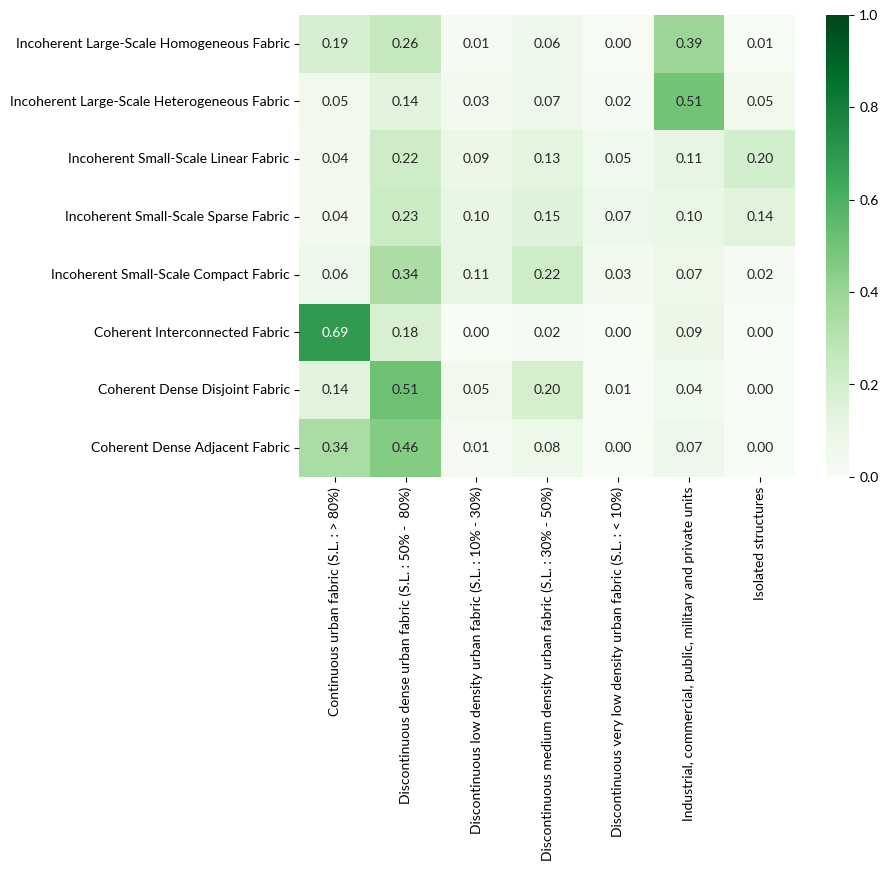

In [16]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(himoc_urbanatlas_tab[selected_cols], cmap='Greens', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax)
plt.savefig('../figs/urbanatlas_l3.png', dpi=300, bbox_inches="tight")

### Level 2

In [47]:
all_data["map_label"] = all_data["final_without_noise"].map(
    cluster_mapping[2].to_dict()
)

In [48]:
himoc_urbanatlas_tab = pd.crosstab(
    all_data.map_label, all_data.class_2018, normalize="index"
)
himoc_urbanatlas_tab.index = himoc_urbanatlas_tab.index.map(get_cluster_names(2)).values

In [49]:
himoc_urbanatlas_tab.columns.name = ""

In [50]:
ua_l2 = himoc_urbanatlas_tab[selected_cols]

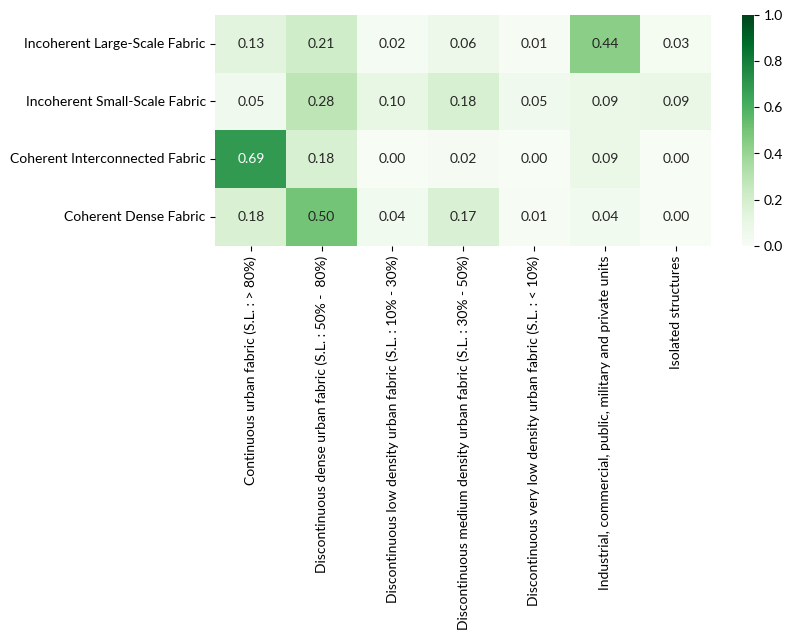

In [30]:
f, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(himoc_urbanatlas_tab[selected_cols], cmap='Greens', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax)
plt.savefig('../figs/urbanatlas_l2.png', dpi=300, bbox_inches="tight")

### Level 1

In [51]:
all_data["map_label"] = all_data["final_without_noise"].map(
    cluster_mapping[1].to_dict()
)

In [52]:
himoc_urbanatlas_tab = pd.crosstab(
    all_data.map_label, all_data.class_2018, normalize="index"
)
himoc_urbanatlas_tab.index = himoc_urbanatlas_tab.index.map(get_cluster_names(1)).values

In [53]:
himoc_urbanatlas_tab.columns.name = ""

In [54]:
ua_l1 = himoc_urbanatlas_tab[selected_cols]

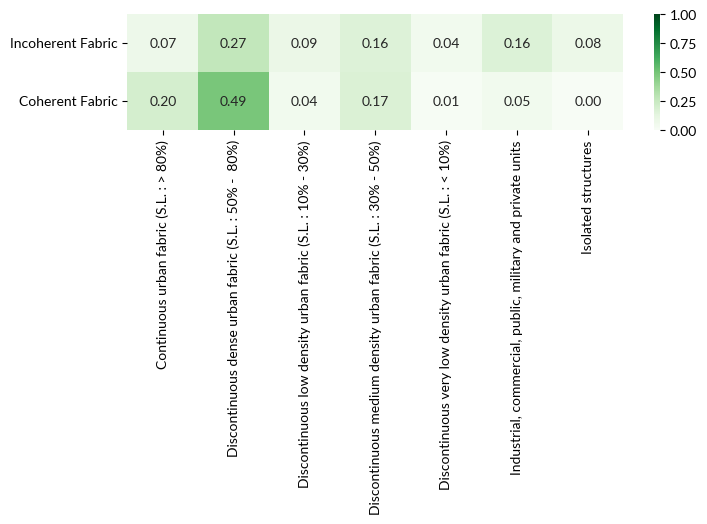

In [35]:
f, ax = plt.subplots(figsize=(8, 1.5))
sns.heatmap(himoc_urbanatlas_tab[selected_cols], cmap='Greens', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax)
plt.savefig('../figs/urbanatlas_l1.png', dpi=300, bbox_inches="tight")

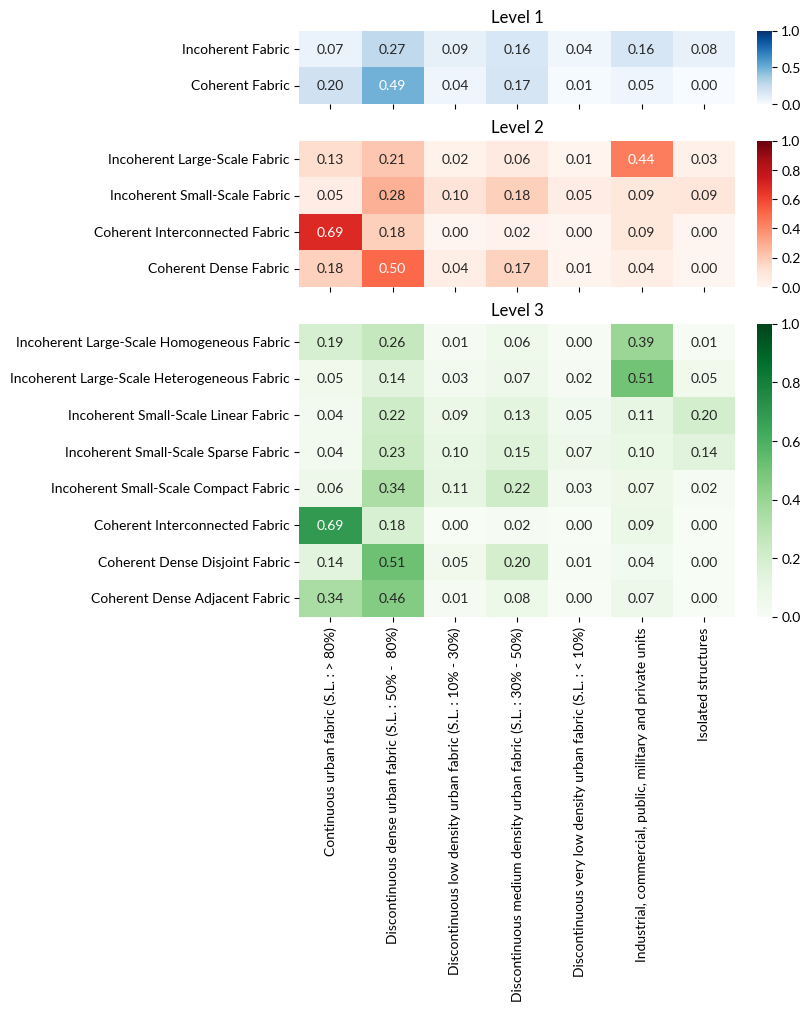

In [68]:
mosaic = """
    AAAAAAA
    AAAAAAA
    BBBBBBB
    BBBBBBB
    BBBBBBB
    BBBBBBB
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    """
fig = plt.figure(layout="constrained", figsize=(8, 10))
ax_dict = fig.subplot_mosaic(mosaic, sharex=True)
sns.heatmap(ua_l1, cmap='Blues', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax_dict['A'], cbar=True, cbar_kws={'aspect': 5})
sns.heatmap(ua_l2, cmap='Reds', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax_dict['B'], cbar=True, cbar_kws={'aspect': 10})
sns.heatmap(ua_l3, cmap='Greens', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax_dict['C'], cbar=True)
ax_dict["A"].set_title('Level 1')
ax_dict["B"].set_title('Level 2')
ax_dict["C"].set_title('Level 3')
plt.savefig('../figs/urbanatlas.png', dpi=300, bbox_inches="tight")

1. The Large Interconnected Blocks	is mainly continuous urban fabric reflecting the fact that they are mainly many interconnected buildings.
2. Dense connected developments is split between continugus and discontiguous because they are buildings with more space between them...
3. Sparse rural is reflected in the standalone structyres and lower density spread,
4. Large Utilitarian Development, Extensive Courtyard Complexes	, Massive Connected Aggregations, Large Wide-Spaced Complexes	is reflected in the large number of industrial
5. The disperesed and road linked clusters are more discontinous low and median density


Overall these relationships highlight that our clusters extend the available classifications, note that each of our clusters can be arbitralily broken down into subclusters based on the hierarchy.

In [20]:
await dfi.export_async(styled_df, "../data/urban_atlas.png", dpi=300)

## LCZ

In [1]:
# !wget https://zenodo.org/records/8419340/files/lcz_filter_v3.tif?download=1

In [2]:
# !mv lcz_filter_v3.tif /data/uscuni-ulce/validation/

In [2]:
furl = "/data/uscuni-ulce/validation/lcz_filter_v3.tif"

In [3]:
lczs = rioxarray.open_rasterio(furl).squeeze()

#### Prague plot to verify spatial join

In [ ]:
%%time

results = []

for region_id in regions.index:
    if region_id != 69333:
        continue

    print(region_id)
    buildings = gpd.read_parquet(
        f"/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq"
    )

    # setup geometry list to burn into the raster
    buildings["num_index"] = np.arange(1, buildings.shape[0] + 1)
    buildings["geometry"] = buildings.representative_point()
    building_utm = buildings.to_crs(lczs.rio.crs)
    minx, miny, maxx, maxy = building_utm.total_bounds

    # read only the region part of the raster data
    region_lczs = rioxarray.open_rasterio(
        filename=furl, chunks="auto", parse_coordinates=True, masked=True
    ).rio.clip_box(minx, miny, maxx, maxy)

    # extract building classification from lcz raster
    aggregated_iterative = region_lczs.xvec.extract_points(
        building_utm.geometry,
        x_coords="x",
        y_coords="y",
    )

    # append to the building dataframe and store in the  results array
    res = aggregated_iterative.to_pandas()
    res = gpd.GeoDataFrame(res.T.reset_index(), crs=building_utm.crs)
    res.columns = ["geometry", "label"]
    building_utm["lcz"] = res["label"].values
    results.append(building_utm)

all_data = pd.concat(results, ignore_index=True)

69333
CPU times: user 2.2 s, sys: 426 ms, total: 2.62 s
Wall time: 2.59 s


In [8]:
import lonboard
from sidecar import Sidecar
from core.cluster_validation import get_color

v = "v3"
final_clusters = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/final_clusters_{v}.pq"
)[0]

final_colors = pd.DataFrame(
    get_color(final_clusters.values), final_clusters.values
).drop_duplicates()
final_colors.loc[-1] = [255, 255, 255]

etcs = all_data.copy()
etcs["geometry"] = all_data.to_crs(epsg=3035).buffer(10).to_crs(epsg=4326)


layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=0.7)


sc = Sidecar(title="Final Clusters")
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

In [9]:
from core.cluster_validation import get_color

layer.get_fill_color = final_colors.loc[etcs.lcz].values.astype("uint8")

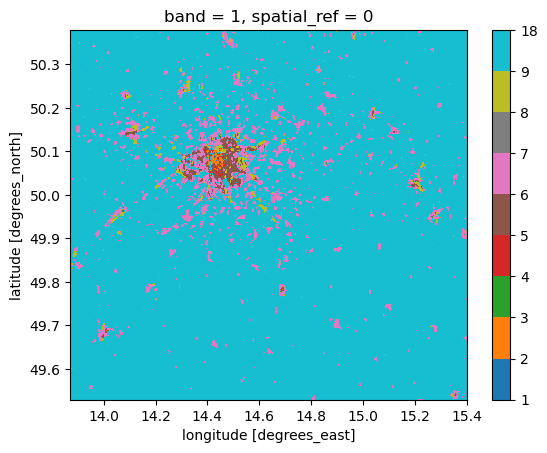

In [10]:
region_lczs.plot(levels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 18], cmap="tab10")

#### Generate spatial join

In [7]:
%%time

results = []

for region_id in regions.index:
    print(region_id)
    buildings = gpd.read_parquet(
        f"/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq"
    )

    # setup geometry list to burn into the raster
    buildings["num_index"] = np.arange(1, buildings.shape[0] + 1)
    buildings["geometry"] = buildings.representative_point()
    building_utm = buildings.to_crs(lczs.rio.crs)
    minx, miny, maxx, maxy = building_utm.total_bounds

    # read only the region part of the raster data
    region_lczs = rioxarray.open_rasterio(
        filename=furl, chunks="auto", parse_coordinates=True, masked=True
    ).rio.clip_box(minx, miny, maxx, maxy)

    # extract building classification from lcz raster
    aggregated_iterative = region_lczs.xvec.extract_points(
        building_utm.geometry,
        x_coords="x",
        y_coords="y",
    )

    # append to the building dataframe and store in the  results array
    res = aggregated_iterative.to_pandas()
    res = gpd.GeoDataFrame(res.T.reset_index(), crs=building_utm.crs)
    res.columns = ["geometry", "label"]
    building_utm["lcz"] = res["label"].values
    results.append(building_utm)

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


In [8]:
all_data = pd.concat(results, ignore_index=True)

In [9]:
del results

### Crossstab

In [10]:
cluster_mapping = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq"
)

In [11]:
lcz_names = {
    "1": "Compact high-rise",
    "2": "Compact mid-rise",
    "3": "Compact low-rise",
    "4": "Open high-rise",
    "5": "Open mid-rise",
    "6": "Open low-rise",
    "7": "Lightweight low-rise",
    "8": "Large low-rise",
    "9": "Sparsely built",
    "10": "Heavy industry",
    "11": "Dense trees",
    "12": "Scattered trees",
    "13": "Bush, scrub",
    "14": "Low plants",
    "15": "Bare rock or paved",
    "16": "Bare soil or sand",
    "17": "Water",
}

lcz_names = {float(k): v for k, v in lcz_names.items()}

### Level 3

In [12]:
all_data["map_label"] = all_data["final_without_noise"].map(
    cluster_mapping[3].to_dict()
)

In [13]:
himoc_lcz_tab = pd.crosstab(all_data.map_label, all_data.lcz, normalize="index")
himoc_lcz_tab.index = himoc_lcz_tab.index.map(get_cluster_names(3)).values
himoc_lcz_tab.columns = himoc_lcz_tab.columns.map(lcz_names).values

In [14]:
himoc_lcz_tab.columns

Index(['Compact high-rise', 'Compact mid-rise', 'Compact low-rise',
       'Open high-rise', 'Open mid-rise', 'Open low-rise',
       'Lightweight low-rise', 'Large low-rise', 'Sparsely built',
       'Heavy industry', 'Dense trees', 'Scattered trees', 'Bush, scrub',
       'Low plants', 'Bare rock or paved', 'Bare soil or sand', 'Water'],
      dtype='object')

In [15]:
selected_cols = [
    "Compact high-rise",
    "Compact mid-rise",
    "Open mid-rise",
    "Open low-rise",
    "Large low-rise",
    "Sparsely built",
    "Heavy industry",
    "Dense trees",
    "Scattered trees",
    "Low plants",
]

In [16]:
lcz_l3 = himoc_lcz_tab[selected_cols]

In [17]:
styled_df = himoc_lcz_tab[selected_cols]

f = {k: "{:.2f}" for k in himoc_lcz_tab.columns.values}
styled_df = himoc_lcz_tab.style.format(f).background_gradient(axis=1, cmap="BuGn")
styled_df

,Compact high-rise,Compact mid-rise,Compact low-rise,Open high-rise,Open mid-rise,Open low-rise,Lightweight low-rise,Large low-rise,Sparsely built,Heavy industry,Dense trees,Scattered trees,"Bush, scrub",Low plants,Bare rock or paved,Bare soil or sand,Water
Incoherent Large-Scale Homogeneous Fabric,0.00,0.01,0.00,0.01,0.15,0.55,0.00,0.11,0.09,0.00,0.01,0.02,0.00,0.05,0.00,0.00,0.00
Incoherent Large-Scale Heterogeneous Fabric,0.00,0.00,0.00,0.00,0.04,0.28,0.00,0.24,0.19,0.00,0.03,0.05,0.00,0.14,0.00,0.00,0.00
Incoherent Small-Scale Linear Fabric,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.37,0.00,0.07,0.14,0.00,0.38,0.00,0.00,0.00
Incoherent Small-Scale Sparse Fabric,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.41,0.00,0.07,0.17,0.00,0.24,0.00,0.00,0.00
Incoherent Small-Scale Compact Fabric,0.00,0.00,0.00,0.00,0.01,0.34,0.00,0.01,0.44,0.00,0.04,0.07,0.00,0.09,0.00,0.00,0.00
Coherent Interconnected Fabric,0.01,0.22,0.03,0.03,0.31,0.34,0.00,0.04,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Coherent Dense Disjoint Fabric,0.00,0.00,0.00,0.00,0.02,0.68,0.00,0.01,0.23,0.00,0.02,0.02,0.00,0.03,0.00,0.00,0.00
Coherent Dense Adjacent Fabric,0.00,0.01,0.01,0.00,0.08,0.78,0.00,0.02,0.08,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00


in all cases more than 70% of the buildings are assigned to 1 or 2 classes.

### Level 2

In [18]:
all_data["map_label"] = all_data["final_without_noise"].map(
    cluster_mapping[2].to_dict()
)

In [19]:
himoc_lcz_tab = pd.crosstab(all_data.map_label, all_data.lcz, normalize="index")
himoc_lcz_tab.index = himoc_lcz_tab.index.map(get_cluster_names(2)).values
himoc_lcz_tab.columns = himoc_lcz_tab.columns.map(lcz_names).values

In [20]:
lcz_l2 = himoc_lcz_tab[selected_cols]

### Level 1

In [21]:
all_data["map_label"] = all_data["final_without_noise"].map(
    cluster_mapping[1].to_dict()
)

In [22]:
himoc_lcz_tab = pd.crosstab(all_data.map_label, all_data.lcz, normalize="index")
himoc_lcz_tab.index = himoc_lcz_tab.index.map(get_cluster_names(1)).values
himoc_lcz_tab.columns = himoc_lcz_tab.columns.map(lcz_names).values

In [23]:
lcz_l1 = himoc_lcz_tab[selected_cols]

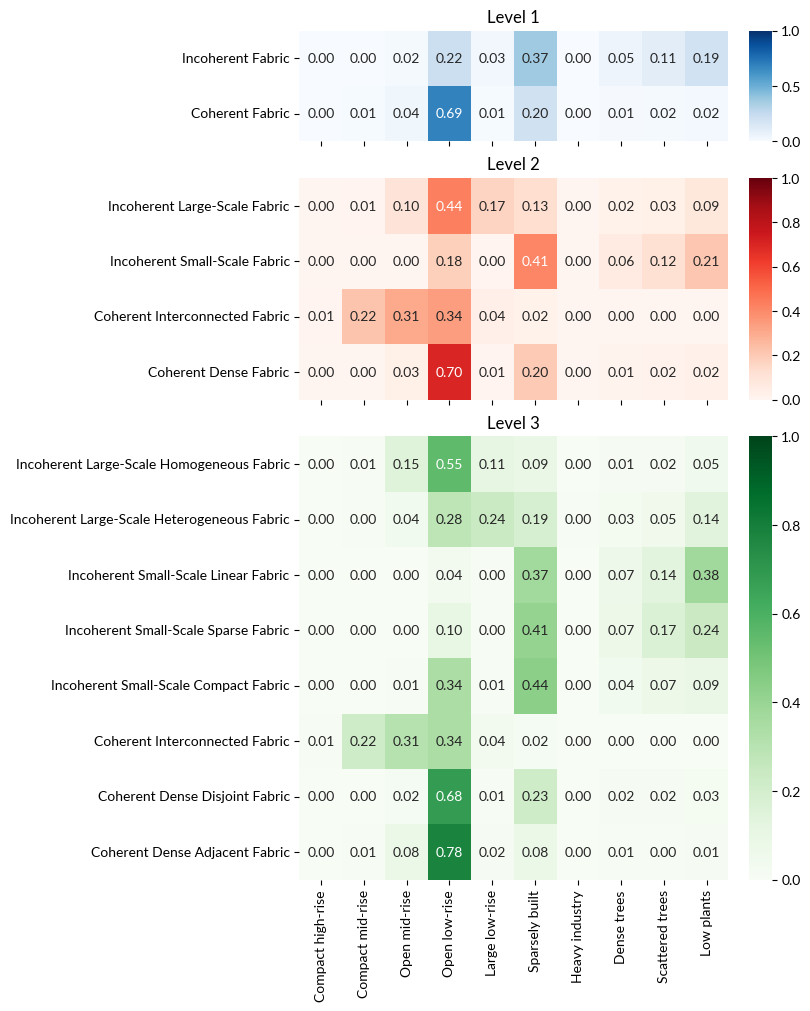

In [24]:
mosaic = """
    AAAAAAA
    AAAAAAA
    BBBBBBB
    BBBBBBB
    BBBBBBB
    BBBBBBB
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    CCCCCCC
    """
fig = plt.figure(layout="constrained", figsize=(8, 10))
ax_dict = fig.subplot_mosaic(mosaic, sharex=True)
sns.heatmap(lcz_l1, cmap='Blues', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax_dict['A'], cbar=True, cbar_kws={'aspect': 5})
sns.heatmap(lcz_l2, cmap='Reds', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax_dict['B'], cbar=True, cbar_kws={'aspect': 10})
sns.heatmap(lcz_l3, cmap='Greens', annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax_dict['C'], cbar=True)
ax_dict["A"].set_title('Level 1')
ax_dict["B"].set_title('Level 2')
ax_dict["C"].set_title('Level 3')
plt.savefig('../figs/lcz.png', dpi=300, bbox_inches="tight")